In [ ]:
import datetime, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow import keras
from keras.layers import Input, LSTM, Dropout, GRU, Dense
from keras.models import Model

from psx import stocks, tickers

In [38]:
#tickers = tickers()

symbol = 'EXIDE'
start = datetime.date(2018, 1, 1)

current_date = datetime.date.today()
current_hour = datetime.datetime.now().hour
# Check if it's a weekday and the time is before 6 PM
if current_date.weekday() < 5 and current_hour < 18:
    end = current_date - datetime.timedelta(days=1) # If yes, set end to the previous date
else:
    end = current_date # Otherwise, use the current date

# Check if the difference between end and start is less than 2 years
if (end - start).days < 365 * 2:
    print("Please increase interval to more than 2 years")
    #sys.exit()

data = stocks(symbol, start=start, end=end)

print(f"Ticker data for {symbol} downloaded successfully.")
print("End Date:", end)

Ticker data for EXIDE downloaded successfully.
End Date: 2023-11-27


In [39]:
# creatin a new column named Avg which will be used as input data
data = data.sort_values('Date')
data['Avg'] = np.mean(data[['Open', 'Close']], axis=1)
data.tail()

,Open,High,Low,Close,Volume,Avg
Date,,,,,,
2023-11-21,378.0,398.0,378.0,390.10,25500.0,384.050
2023-11-22,392.5,392.5,380.0,386.05,15800.0,389.275
2023-11-23,385.0,395.0,385.0,386.99,10600.0,385.995
2023-11-24,392.0,396.0,388.0,394.41,14100.0,393.205
2023-11-27,398.0,409.5,398.0,404.77,23100.0,401.385


In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=(symbol, 'Volume'))

# Add candlestick chart to the first subplot
candlestick = go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick')
fig.add_trace(candlestick, row=1, col=1)

# Add volume bars to the second subplot
volume_bars = go.Bar(x=data.index, y=data['Volume'], marker_color="blue", name='Volume')
fig.add_trace(volume_bars, row=2, col=1)

# Update layout
fig.update_layout(title=f"{symbol} Stocks",
                  yaxis_title="Price (PKR)",
                  width=1200,
                  height=700)

# Hide the x-axis rangeslider
fig.update(layout_xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


Selecting 'Avg' as the base data for training and inference

In [41]:
D = data[['Avg']]   # put only 'Avg' values in array 'D'

D.tail()

,Avg
Date,
2023-11-21,384.050
2023-11-22,389.275
2023-11-23,385.995
2023-11-24,393.205
2023-11-27,401.385


In [42]:
loop_back = 100
X, y = [], []

for i in range(len(D)-loop_back):
    X0, Xn, yn = i, i+loop_back, i+loop_back
    X_slice = D.iloc[X0:Xn, 0].values  #setting 'seq_len' prior values as predictor
    y_slice = D.iloc[yn, 0]            #setting next-to-predictor value as lable
    X.append(X_slice)
    y.append(y_slice)

X = np.array(X)
y = np.array(y)

In [43]:
X,y

(array([[405.5  , 409.4  , 412.5  , ..., 389.   , 380.05 , 378.005],
        [409.4  , 412.5  , 429.385, ..., 380.05 , 378.005, 382.5  ],
        [412.5  , 429.385, 438.5  , ..., 378.005, 382.5  , 383.125],
        ...,
        [264.5  , 274.545, 293.56 , ..., 372.365, 384.05 , 389.275],
        [274.545, 293.56 , 291.7  , ..., 384.05 , 389.275, 385.995],
        [293.56 , 291.7  , 292.525, ..., 389.275, 385.995, 393.205]]),
 array([382.5  , 383.125, 386.35 , ..., 385.995, 393.205, 401.385]))

In [44]:
split = 365 #if D.shape[0] > 365*2 else int(D.shape[0]/2)

X_train, y_train = X[:-split], y[:-split]
X_test,  y_test  = X[-split:], y[-split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(931, 100) (931,) (365, 100) (365,)


In [45]:
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))#.reshape(-1)   
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))#.reshape(-1)

In [46]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((931, 100), (365, 100), (931, 1), (365, 1))

In [47]:
X_train_scaled_3d = np.reshape(X_train_scaled, (-1, X_train_scaled.shape[1], 1))
X_test_scaled_3d  = np.reshape(X_test_scaled,  (-1, X_test_scaled.shape[1], 1))

In [48]:
X_train_scaled_3d.shape, X_test_scaled_3d.shape, y_train_scaled.shape, y_test_scaled.shape

((931, 100, 1), (365, 100, 1), (931, 1), (365, 1))

In [49]:
# Input layer
input_shape = (X_train_scaled_3d.shape[1], X_train_scaled_3d.shape[2])  # skipping sequencing axis
inputs = Input(shape=input_shape)

# LSTM layer with return_sequences=True
x = LSTM(units=50, return_sequences=True)(inputs)
x = Dropout(0.1)(x)

# LSTM layer with return_sequences=True
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# GRU layer
x = GRU(units=50)(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(units=1)(x)

# Creating the functional model
model = Model(inputs=inputs, outputs=outputs)

In [50]:
from keras.optimizers import Adam
from keras.losses import mse

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam_optimizer, loss=mse)

In [51]:
model.fit(X_train_scaled_3d, y_train_scaled, epochs=20, batch_size=32)

Epoch 1/8
30/30 [==============================] - 5s 50ms/step - loss: 0.0341
Epoch 2/8
30/30 [==============================] - 2s 52ms/step - loss: 0.0072
Epoch 3/8
30/30 [==============================] - 1s 49ms/step - loss: 0.0055
Epoch 4/8
30/30 [==============================] - 1s 48ms/step - loss: 0.0053
Epoch 5/8
30/30 [==============================] - 1s 48ms/step - loss: 0.0045
Epoch 6/8
30/30 [==============================] - 1s 48ms/step - loss: 0.0044
Epoch 7/8
30/30 [==============================] - 1s 48ms/step - loss: 0.0043
Epoch 8/8
30/30 [==============================] - 1s 48ms/step - loss: 0.0041


In [52]:
y_pred = model.predict(X_test_scaled_3d)

12/12 [==============================] - 1s 13ms/step


In [53]:
rmse = np.sqrt(np.mean((y_pred - y_test_scaled)**2))
rmse

0.03320780314643457

### de-normalization of the test and predicted values (conversion in PKR)

In [54]:
rmse_denormalized = y_scaler.inverse_transform(rmse.reshape(-1, 1)).flatten()   #inverse transform expects column data, scaler expects 1D
rmse_denormalized

array([79.95174978])

In [55]:
y_pred = np.reshape(y_pred, y_test_scaled.shape) # conversin to same shape y_test_scaled 

y_test_scaled.shape, y_pred.shape

((365, 1), (365, 1))

In [56]:
# Denormalization using inverse_transform
y_true_denormalized = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()   #inverse transform expects column data, scaler expects 1D
y_pred_denormalized = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [57]:
y_true_denormalized.shape, y_pred_denormalized.shape

((365,), (365,))

In [58]:
#verifying last value of y_true & y_pred
y_true_denormalized[-1], y_pred_denormalized[-1]

(401.385, 366.61047)

Packing the data in a dataframe with index value

In [59]:
# Create a DataFrame named 'display'
display = pd.DataFrame(index=D[-split:].index)
display['y_true'] = y_true_denormalized
display['y_pred'] = y_pred_denormalized

display.tail()

,y_true,y_pred
Date,,
2023-11-21,384.050,353.376831
2023-11-22,389.275,356.253174
2023-11-23,385.995,359.553589
2023-11-24,393.205,363.004700
2023-11-27,401.385,366.610474


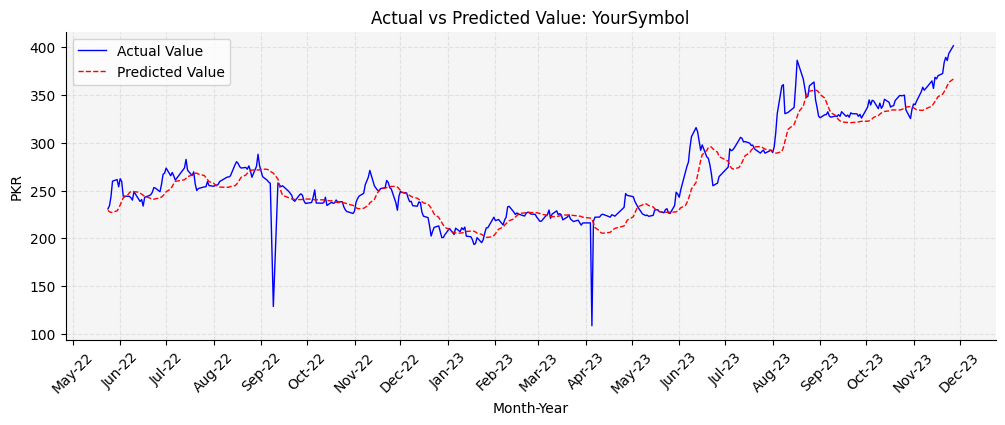

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase DPI for better resolution
plt.rcParams['figure.dpi'] = 100

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot 'y_true' and 'y_pred' with fine lines
ax.plot(display.index, display['y_true'], label='Actual Value', color='blue', linewidth=1, linestyle='-')
ax.plot(display.index, display['y_pred'], label='Predicted Value', color='red', linewidth=1, linestyle='--')

# Customize appearance
ax.set(xlabel='Month-Year', ylabel='PKR', title=f'Actual vs Predicted Value: {symbol}')
ax.legend(loc='upper left')
plt.xticks(rotation=45)

# Customize x-axis date format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Set a light background color
ax.set_facecolor('#F5F5F5')

# Set a light grid color
ax.grid(True, linestyle='--', alpha=0.7, color='#D9D9D9')

# Remove top and right spines for aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()
